## Older Approach which will lead to the new approach

In [ ]:
import google.generativeai as genai
from google.colab import userdata
from paddleocr import PaddleOCR
from PIL import Image

# Set up Gemini API
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

# Initialize OCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # Adjust language if needed

# Function to extract text from the image
def extract_text_from_image(image_path):
    img = Image.open(image_path)
    result = ocr.ocr(image_path, cls=True)
    try:
      extracted_text = "\n".join([line[1][0] for line in result[0]])
    except:
      print(f"[DEBUG] OCR Result: {result}")
    print(f"[DEBUG] Extracted Text:\n{extracted_text}")
    return extracted_text

# Function to classify extracted text using Gemini API
def classify_text_with_gemini(text):
    model = genai.GenerativeModel('models/gemini-1.5-flash')
    # Update the prompt to specifically ask for manufacturing and expiration dates
    response = model.generate_content(f"Analyze the following text and extract both the manufacturing and expiration dates. The text may contain unclear or partially obscured information, and dates may not be on the same line. Please provide the extracted dates in the format: Manufacturing Date, Expiration Date. If a date is missing, replace it with -1. The text is: {text}")
    print(f"[DEBUG] Gemini Response:\n{response.text}")
    return response.text

# Main processing function
def process_image(image_path):
    # Extract text from the image
    extracted_text = extract_text_from_image(image_path)

    # Classify text using Gemini API
    classified_result = classify_text_with_gemini(extracted_text)

    return classified_result

# Example usage
image_path = "sample_img2.jpg"  # Replace with your image path
result = process_image(image_path)
print(f"[DEBUG] Final Classification Result:\n{result}")


[2024/10/12 19:49:56] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

[2024/10/12 19:58:11] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

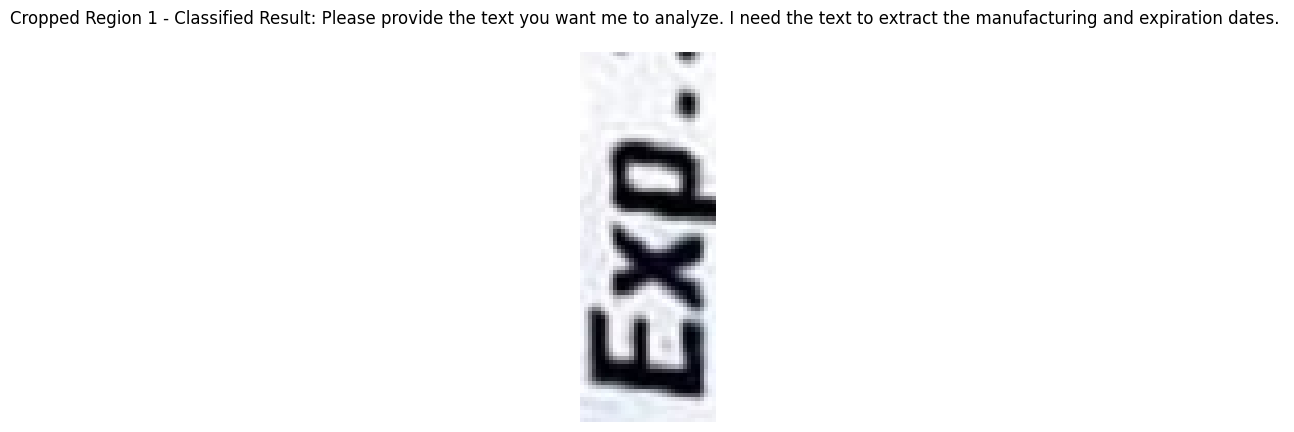

In [ ]:
import cv2
import matplotlib.pyplot as plt
import google.generativeai as genai
from paddleocr import PaddleOCR

# Initialize OCR with detection enabled
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Set up Gemini API
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

def classify_dates_with_gemini(text):
    # Call the Gemini API to classify and extract dates
    model = genai.GenerativeModel('models/gemini-1.5-flash')
    response = model.generate_content(
        f"Analyze the following text and extract both the manufacturing and expiration dates: {text}. "
        "If a date is missing, use -1 as a placeholder."
    )
    return response.text

def detect_and_crop_date_region(image_path):
    # Read image using OpenCV
    img = cv2.imread(image_path)

    # Use PaddleOCR to detect text regions
    result = ocr.ocr(image_path, cls=True)

    # Find regions with potential keywords like 'MFD', 'EXP', etc.
    date_boxes = []
    for line in result[0]:
        text = line[1][0].lower()  # Convert to lowercase for keyword matching
        if any(keyword in text for keyword in ['exp', 'expiry', 'mfd', 'best before']):
            date_boxes.append((line[0], text))  # Store the bounding box and text

    # Crop the identified regions, classify them with Gemini, and display
    classified_dates = []
    for idx, (box, text) in enumerate(date_boxes):
        # Convert coordinates to integers
        x1, y1 = int(box[0][0]), int(box[0][1])
        x2, y2 = int(box[2][0]), int(box[2][1])
        cropped = img[y1:y2, x1:x2]  # Crop the region

        # Classify the cropped region with the Gemini API
        classified_result = classify_dates_with_gemini(text)
        classified_dates.append((classified_result, cropped))

        # Display the cropped region with classified result
        plt.figure()
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title(f"Cropped Region {idx + 1} - Classified Result: {classified_result}")
        plt.axis('off')
        plt.show()

    return classified_dates

# Example usage
image_path = 'sample_img2.jpg'  # Replace with your image path
cropped_regions = detect_and_crop_date_region(image_path)


In [ ]:
!git clone https://github.com/ultralytics/yolov5  # YOLOv5 repository
%cd yolov5
!pip install -r requirements.txt paddleocr


Cloning into 'yolov5'...
remote: Enumerating objects: 16982, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 16982 (delta 90), reused 110 (delta 54), pack-reused 16805 (from 1)
Receiving objects: 100% (16982/16982), 15.71 MiB | 17.43 MiB/s, done.
Resolving deltas: 100% (11628/11628), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 882.7/882.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.5 MB/s eta 0:00:00


In [ ]:
import torch
from paddleocr import PaddleOCR
import cv2

# Initialize OCR
ocr = PaddleOCR(use_angle_cls=True, lang='en')

# Load YOLOv5 model (you can train your custom model if needed)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # Use yolov5s.pt as a baseline

def detect_regions(image_path):
    # Run YOLOv5 on the input image
    results = model(image_path)
    results.print()
    results.save()  # Save detected results for visualization

    # Extract detected regions
    return results.pandas().xyxy[0]  # Dataframe with bounding boxes and labels


[2024/10/12 19:58:56] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c

Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2024-10-12 Python-3.10.12 torch-2.4.1+cu121 CPU

100%|██████████| 14.1M/14.1M [00:00<00:00, 162MB/s]

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [ ]:
def ocr_and_analyze(image_path, bounding_boxes):
    img = cv2.imread(image_path)
    detected_texts = []

    for idx, row in bounding_boxes.iterrows():
        # Extract bounding box coordinates
        x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        cropped = img[y1:y2, x1:x2]

        # Apply OCR to the cropped region
        result = ocr.ocr(cropped, cls=True)
        text = "\n".join([line[1][0] for line in result[0]])
        detected_texts.append((text, (x1, y1, x2, y2)))

    return detected_texts


In [ ]:
def classify_dates(detected_texts):
    mfg_date, exp_date = None, None

    # Check each detected text for keywords and context
    for text, bbox in detected_texts:
        if any(keyword in text.lower() for keyword in ['mfd', 'manufactured']):
            mfg_date = text
        elif any(keyword in text.lower() for keyword in ['exp', 'expiry', 'best before']):
            exp_date = text

    return mfg_date, exp_date


## Latest Approach

### The PaddleOCR + Gemini combined type model.

Run these 4 cells before trying out any model

In [1]:
!pip install google-generativeai
!pip install paddleocr
!pip install paddlepaddle


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.5/407.5 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114250 sha256=5cbadadc7e1a5bc86ea3f559feb0cdef800fc6be55bf35bd77a323b405cdf9bb
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import matplotlib.pyplot as plt
from PIL import Image  # Import Image from the Pillow library

# Function to draw bounding boxes and show text
def draw_bounding_boxes(image_path):
    # Read the image
    img = Image.open(image_path)
    result = ocr.ocr(image_path, cls=True)  # Get the OCR result

    # Create a figure to display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    ax = plt.gca()
    all_text_data = []
    # Iterate through the results and draw boxes
    for idx, line in enumerate(result[0]):
        box = line[0]  # Get the bounding box coordinates
        text = line[1][0]  # Extracted text
        print(f"[DEBUG] Box {idx + 1}: {text}")  # Display text with box number
        all_text_data.append(f"{text}")

        # Draw the bounding box
        polygon = plt.Polygon(box, fill=None, edgecolor='red', linewidth=2)
        ax.add_patch(polygon)
        # Add text label in the box
        # ax.text(box[0][0], box[0][1] - 5, f"{idx + 1}: {text}", color='blue', fontsize=12)

    plt.axis('off')  # Hide axes
    plt.show()
    return all_text_data



In [3]:
import google.generativeai as genai
from google.colab import userdata

# Set your API key securely (store it in Colab’s userdata)
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')  # Replace with your API Key if needed
genai.configure(api_key=GOOGLE_API_KEY)

def gemini_context_correction(text):
    """Use Gemini API to refine noisy OCR results and extract MRP details."""
    model = genai.GenerativeModel('models/gemini-1.5-flash')

    response = model.generate_content(
        f"Identify and extract manufacturing, expiration dates, and MRP from the following text. "
        f"The dates may be written in dd/mm/yyyy format or as <Month_name> <Year> or <day> <Month_Name> <Year>. "
        f"The text may contain noise or unclear information. If only one date is provided, assume it is the Expiration Date. "
        f"Additionally, extract the MRP (e.g., 'MRP: ₹99.00', 'Rs. 99/-'). "
        f"Format the output as:\n"
        f"Manufacturing Date: <MFG Date>\n"
        f"Expiration Date: <EXP Date>\n"
        f"MRP: <MRP Value>\n\n"
        f"Here is the text: {text}"
    )

    return response.text

# Test Gemini with example text (replace with actual OCR output)
sample_text = "EXP 12/2024 MFD 08/2023 Best Before 06/2025 MRP Rs. 250/-"
refined_output = gemini_context_correction(sample_text)
print("[DEBUG] Gemini Refined Output:\n", refined_output)


[DEBUG] Gemini Refined Output:
 Manufacturing Date: 08/2023
Expiration Date: 12/2024
MRP: Rs. 250/- 



In [4]:
def validate_dates_with_gemini(mfg_date, exp_date):
    """Use Gemini API to validate and correct the manufacturing and expiration dates."""
    model = genai.GenerativeModel('models/gemini-1.5-flash')
    response = model.generate_content(
        f"Please provide the final Manufacturing Date and Expiration Date based on the following: "
        f"Manufacturing Date: {mfg_date}, Expiration Date: {exp_date}. "
        f"Based on these dates, can you check if they are logically correct. If the expiry is less than mfg then they need to be swapped. "
        f"Also, if the dates seem to be logically incorrect, decide what could be the possible date. When returning any output, just return the dates in the format: "
        f"Manufacturing Date: <MFG Date>, Expiration Date: <EXP Date>. Nothing else at all"
        f"If a date is '-1', it means it doesn't exist, so leave it unchanged."
    )

    # Check if the response contains valid parts
    if response.parts:
        # Process the response to extract final dates
        final_dates = response.parts[0].text.strip()
        return final_dates

    # Return a message or a default value if no valid parts are found
    return "Invalid response from Gemini API."



def extract_date(refined_text, date_type):
    """Extract the specified date type from the refined text."""
    if date_type in refined_text:
        try:
            # Split the text and find the date for the specified type
            parts = refined_text.split(',')
            for part in parts:
                if date_type in part:
                    return part.split(':')[1].strip()  # Return the date value
        except IndexError:
            return '-1'  # Return -1 if the date is not found
    return '-1'  # Return -1 if the date type is not in the text



### **Model 1**
Without Yolo model and without any front-end user interface

In [7]:
import cv2
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR
from google.colab import files

# Upload the image in Colab and retrieve the path dynamically
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Dynamically get the uploaded filename

# Initialize PaddleOCR with detection enabled
ocr = PaddleOCR(use_angle_cls=True, lang='en')

def detect_and_analyze_regions(image_path):
    # Load the image and handle possible errors
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not load image at {image_path}. Check the path or format.")

    height, width, _ = img.shape
    part_height = height // 3
    ocr_results = []

    # Process the image in 3 vertical parts
    for i in range(3):
        y1, y2 = i * part_height, (i + 1) * part_height if i < 2 else height
        region = img[y1:y2, :]

        # Perform OCR on the region
        result = ocr.ocr(region, cls=True)
        if result and result[0]:  # Ensure there are valid results
            text_data = "\n".join([line[1][0] for line in result[0]])
            ocr_results.append(text_data)
        else:
            print(f"[DEBUG] No text detected in Region {i + 1}")

    # Combine all OCR text from the regions
    if ocr_results:
        combined_text = " ".join(ocr_results)+"\n"
        bounding_boxes_list= draw_bounding_boxes(image_path)
        print("[DEBUG] ",bounding_boxes_list, type(bounding_boxes_list))

        for text in bounding_boxes_list:
          combined_text += text
          combined_text += "\n"
        print("[DEBUG] combined tect", combined_text)
        # print("Combined Text\n", combined_text)
        # Send the combined text to Gemini for correction/analysis
        refined_text = gemini_context_correction(combined_text)
        print("[DEBUG] Gemini Refined Text:\n", refined_text)

        # Validate and correct dates
        mfg_date = extract_date(refined_text, "Manufacturing Date")
        exp_date = extract_date(refined_text, "Expiration Date")
        # Validate the dates using Gemini
        validated_output = validate_dates_with_gemini(mfg_date, exp_date)
        print("[DEBUG] Validated Output from Gemini:\n", validated_output)

        return validated_output
    else:
        print("[DEBUG] No text detected in any of the regions.")
        return None

# Example usage
final_output = detect_and_analyze_regions(image_path)

# Example usage

KeyboardInterrupt: 

### **Model 2**
With Yolov8 n-model trained for 50 epochs
and
Gradio as user interface
(in case model fails, we fall back to the approach from model 1)


In [5]:
!pip install gradio
!pip install -q gradio ultralytics
from google.colab import drive
drive.mount('/content/drive')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.6/436.6 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 97.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.4 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.1
    Uninstalling MarkupSafe-3.0.1:
      Successfully uninstalled MarkupSafe-3.0.1
  Attempting uninstall: huggingface-hu

In [22]:
import matplotlib.pyplot as plt
from PIL import Image  # Import Image from the Pillow library
import numpy as np  # Import NumPy

def new_draw_bounding_boxes(image):
    """Draw bounding boxes around detected text in the image and display it."""
    # If the input is a string (file path), open the image
    if isinstance(image, str):
        img = Image.open(image)
        np_img = np.array(img)  # Convert to NumPy array
        ocr_result = ocr.ocr(np_img, cls=True)  # Perform OCR on the array
    elif isinstance(image, Image.Image):
        np_img = np.array(image)  # Convert PIL Image to NumPy array
        ocr_result = ocr.ocr(np_img, cls=True)  # Perform OCR on the array
    else:
        raise ValueError("Input must be a file path or a PIL Image object.")

    # Create a figure to display the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    all_text_data = []

    # Iterate through the OCR results and draw boxes
    for idx, line in enumerate(ocr_result[0]):
        box = line[0]  # Get the bounding box coordinates
        text = line[1][0]  # Extracted text
        print(f"[DEBUG] Box {idx + 1}: {text}")  # Debug print
        all_text_data.append(text)

        # Draw the bounding box
        polygon = plt.Polygon(box, fill=None, edgecolor='red', linewidth=2)
        ax.add_patch(polygon)

        # Add text label with a small offset for visibility
        x, y = box[0][0], box[0][1]
        ax.text(x, y - 5, f"{idx + 1}: {text}", color='blue', fontsize=12, ha='left')

    plt.axis('off')  # Hide axes
    plt.title("Detected Text with Bounding Boxes", fontsize=16)  # Add a title
    plt.show()

    return all_text_data


In [23]:
import cv2
import numpy as np
import gradio as gr
from ultralytics import YOLO
from paddleocr import PaddleOCR
from datetime import datetime

# Load YOLOv8 model and PaddleOCR
model_path = "/content/drive/MyDrive/OCR_Using_model/Yolo_Dataset/FlipkartGrid-OCR-1/runs/detect/train2/weights/best.pt"
model = YOLO(model_path)
ocr = PaddleOCR(use_angle_cls=True, lang='en')  # Initialize PaddleOCR

def detect_and_ocr(image):
    """Detect objects using YOLO, draw bounding boxes, and perform OCR without cropping."""
    # Convert input image from PIL to OpenCV format
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Run inference using YOLO model
    results = model(image)
    boxes = results[0].boxes.xyxy.cpu().numpy()  # Extract bounding box coordinates

    extracted_texts = []
    for (x1, y1, x2, y2) in boxes:
        # Draw bounding box on the original image
        cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

        # Perform OCR on the detected region using the original image and bounding box coordinates
        region = image[int(y1):int(y2), int(x1):int(x2)]
        ocr_result = ocr.ocr(region, cls=True)
        # print("DEBUG: ", ocr_result)
        # Check if ocr_result is None or empty
        if ocr_result and isinstance(ocr_result, list) and ocr_result[0]:
            for idx, line in enumerate(ocr_result[0]):
                box = line[0]  # Get the bounding box coordinates
                text = line[1][0]  # Extracted text
                print(f"[DEBUG] Box {idx + 1}: {text}")  # Debug output
                extracted_texts.append(text)
        else:
            print(f"[DEBUG] No OCR result for region: ({x1}, {y1}, {x2}, {y2}) or OCR returned None")

    # Convert image to RGB for Gradio display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Join all extracted texts into a single string
    result_text = "\n".join(str(text) for text in extracted_texts)

    # Call the Gemini context correction function
    refined_text = gemini_context_correction(result_text)
    print("[DEBUG] Gemini Refined Text:\n", refined_text)

    # Validate and correct dates
    mfg_date = extract_date(refined_text, "Manufacturing Date")
    exp_date = extract_date(refined_text, "Expiration Date")
    validated_output = validate_dates_with_gemini(mfg_date, exp_date)
    print("[DEBUG] Validated Output from Gemini:\n", validated_output)

    # Check if further processing is needed
    return image_rgb, result_text, refined_text, validated_output
def further_processing(image, previous_result_text):
    bounding_boxes_list= new_draw_bounding_boxes(image)
    print("[DEBUG] ",bounding_boxes_list, type(bounding_boxes_list))
    combined_text=previous_result_text
    for text in bounding_boxes_list:
      combined_text += text
      combined_text += "\n"
    print("[DEBUG] combined tect", combined_text)
    # Call Gemini for context correction and refinement
    refined_output = gemini_context_correction(combined_text)
    print("[DEBUG] Gemini Refined Output:\n", refined_output)

    return refined_output  # Return refined output for display

def handle_processing(validated_output):
    """Decide whether to proceed with further processing."""
    # Extract the manufacturing and expiration dates from the string
    try:
        mfg_date_str = validated_output.split("Manufacturing Date: ")[1].split(",")[0].strip()
        exp_date_str = validated_output.split("Expiration Date: ")[1].strip()

        # Convert the extracted values to integers
        mfg_date = int(mfg_date_str)
        exp_date = int(exp_date_str)
        print("Further processing: ",mfg_date, exp_date)

    except (IndexError, ValueError) as e:
        print(f"[ERROR] Failed to parse dates: {e}")
        return gr.update(visible=False)  # Hide button on error

    # Check if both dates are -1
    if mfg_date == -1 and exp_date == -1:
        print("[DEBUG] Showing the 'Further Processing' button.")  # Debug print
        return gr.update(visible=True)  # Show 'Further Processing' button
    print("[DEBUG] Hiding the 'Further Processing' button.")  # Debug print
    return gr.update(visible=False)  # Hide button if dates are valid

# Define Gradio interface
with gr.Blocks() as demo:
    # Input: Upload image
    input_image = gr.Image(type="pil", label="Upload Image")

    # Outputs
    output_image = gr.Image(label="Image with Bounding Boxes")
    extracted_textbox = gr.Textbox(label="Extracted Text")
    refined_textbox = gr.Textbox(label="Refined Text from Gemini")
    validated_textbox = gr.Textbox(label="Validated Output")  # New output for validation text

    further_button = gr.Button("Further Processing", visible=False)
    # Detect and OCR button click event
    btn = gr.Button("Detect and OCR")
    btn.click(
        detect_and_ocr,
        inputs=[input_image],
        outputs=[output_image, extracted_textbox, refined_textbox, validated_textbox]  # Added validated_textbox as output
    )


    # Further processing button click event
    further_button.click(
        further_processing,
        inputs=[input_image, extracted_textbox],
        outputs=refined_textbox
    )

    # Monitor validated output to control button visibility
    validated_textbox.change(
        handle_processing,
        inputs=[validated_textbox],  # Monitor validated_textbox for changes
        outputs=[further_button],  # Update visibility of the button
    )

# Launch the Gradio interface
demo.launch(share=True, debug=True)


[2024/10/16 11:16:12] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_c


0: 384x640 1 Label, 132.0ms
Speed: 7.4ms preprocess, 132.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
[2024/10/16 11:16:31] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.02101922035217285
[2024/10/16 11:16:31] ppocr DEBUG: cls num  : 1, elapsed : 0.014834880828857422
[2024/10/16 11:16:31] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07931160926818848
[DEBUG] Box 1: Reg.No.3A 1412/35
[DEBUG] Gemini Refined Text:
 Manufacturing Date: Not Found
Expiration Date: Not Found
MRP: Not Found 

[DEBUG] Validated Output from Gemini:
 Manufacturing Date: -1, Expiration Date: -1
Further processing:  -1 -1
[DEBUG] Showing the 'Further Processing' button.
[2024/10/16 11:16:42] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.14814305305480957
[2024/10/16 11:16:42] ppocr DEBUG: cls num  : 6, elapsed : 0.0643916130065918
[2024/10/16 11:16:43] ppocr DEBUG: rec_res num  : 6, elapsed : 0.5606539249420166
[DEBUG] Box 1: Reg.No.3A 1412/35
[DEBUG] Box 2: Lot &Contro1No.17572
[DEBUG] Box 3: Mfg.

### **Model 3**
Using Yolov8 x-large model trained till about 75 epochs
and
Gradio as user interface
(in case model fails, we fall back to the approach from model 1)
